In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ① データ読み込み
train = pd.read_csv('../data/train.csv')  
train.head()



,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# データ読み込み
train = pd.read_csv('../data/train.csv')

# ターゲットと特徴量に分離
X = train.drop(['Listening_Time_minutes', 'id', 'Podcast_Name', 'Episode_Title'], axis=1)
y = train['Listening_Time_minutes']

# 欠損値を中央値で埋める
imputer = SimpleImputer(strategy='median')
X_num = X.select_dtypes(include=[np.number])
X_num = pd.DataFrame(imputer.fit_transform(X_num), columns=X_num.columns)

# カテゴリ変数をLabel Encoding
X_cat = X.select_dtypes(include=['object'])
for col in X_cat.columns:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col].astype(str))

# 数値とカテゴリを結合
X = pd.concat([X_num, X_cat], axis=1)

# 学習データと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBMのモデルを作成
model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    n_estimators=100
)

# モデル学習
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    callbacks=[lgb.early_stopping(10)],
)

# 検証データで予測
y_pred = model.predict(X_valid)

# RMSEを計算
rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f'Validation RMSE: {rmse:.5f}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 8
[LightGBM] [Info] Start training from score 45.447808
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 13.0766
Validation RMSE: 13.07659


Lightgbm:13.07659

In [23]:
test = pd.read_csv('../data/test.csv')
# 特徴量だけ取り出す
X_test = test.drop(['id', 'Podcast_Name', 'Episode_Title'], axis=1)

# 数値データ欠損補完
X_num_test = X_test.select_dtypes(include=[np.number])
X_num_test = pd.DataFrame(imputer.transform(X_num_test), columns=X_num_test.columns)

# カテゴリ変数ラベルエンコード
X_cat_test = X_test.select_dtypes(include=['object'])
for col in X_cat_test.columns:
    le = LabelEncoder()
    X_cat_test[col] = le.fit_transform(X_cat_test[col].astype(str))

# 数値とカテゴリ結合
X_test = pd.concat([X_num_test, X_cat_test], axis=1)

# 予測
test_preds = model.predict(X_test)

# 提出用データフレーム作成
submission = pd.DataFrame({
    'id': test['id'],
    'Listening_Time_minutes': test_preds
})

# 小数点3桁に丸める
submission['Listening_Time_minutes'] = submission['Listening_Time_minutes'].round(3)

# CSV保存
submission.to_csv('submission.csv', index=False)

print('submission.csvを作成しました！')

submission.csvを作成しました！


CatBoost版

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

# 1. データ読み込み
train = pd.read_csv('../data/train.csv')

# 2. 前処理
X = train.drop(['Listening_Time_minutes', 'id', 'Podcast_Name', 'Episode_Title'], axis=1)
y = train['Listening_Time_minutes']

cat_features = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

# 数値データの欠損値を中央値で埋める
X[X.select_dtypes(include=[np.number]).columns] = X.select_dtypes(include=[np.number]).fillna(X.select_dtypes(include=[np.number]).median())

# カテゴリデータの欠損値は"Unknown"で埋める
X[cat_features] = X[cat_features].fillna('Unknown')

# 3. 学習・検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. CatBoostモデルを作成
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    cat_features=cat_features,
    verbose=100
)

# 5. 学習
model.fit(X_train, y_train, eval_set=(X_valid, y_valid))

# 6. 予測（←ここを必ずCatBoostモデルで）
y_pred = model.predict(X_valid)

# 7. 評価
rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f'Validation RMSE: {rmse:.5f}')

0:	learn: 26.1389566	test: 26.1229636	best: 26.1229636 (0)	total: 245ms	remaining: 4m 4s
100:	learn: 13.2100656	test: 13.1661613	best: 13.1661613 (100)	total: 15.8s	remaining: 2m 20s
200:	learn: 13.1756782	test: 13.1381753	best: 13.1381753 (200)	total: 29s	remaining: 1m 55s
300:	learn: 13.1476428	test: 13.1189552	best: 13.1189552 (300)	total: 42.5s	remaining: 1m 38s
400:	learn: 13.1193039	test: 13.1013584	best: 13.1013584 (400)	total: 1m 1s	remaining: 1m 31s
500:	learn: 13.0981775	test: 13.0899580	best: 13.0899580 (500)	total: 1m 19s	remaining: 1m 19s
600:	learn: 13.0787296	test: 13.0805262	best: 13.0805262 (600)	total: 1m 40s	remaining: 1m 6s
700:	learn: 13.0596037	test: 13.0711924	best: 13.0711924 (700)	total: 2m 3s	remaining: 52.6s
800:	learn: 13.0430735	test: 13.0645986	best: 13.0645986 (800)	total: 2m 23s	remaining: 35.7s
900:	learn: 13.0275980	test: 13.0585076	best: 13.0585076 (900)	total: 2m 42s	remaining: 17.9s
999:	learn: 13.0123851	test: 13.0528870	best: 13.0528870 (999)	tota

Catboost:13.05289

XGBoost Regressor版

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna
import xgboost as xgb

# グラフの設定
ncols = 3
nrows = (len(feature_names) + ncols - 1) // ncols  # 必要な行数を計算

import matplotlib.pyplot as plt

# データ読み込み
train = pd.read_csv('../data/train.csv')

# 1. 不要なカラムを削除
drop_cols = ['id', 'Podcast_Name', 'Episode_Title']
train = train.drop(columns=drop_cols)

cat_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))

# ① かける倍率を決めるマッピングを作成
sentiment_multiplier = {
    'Positive': 0.750,
    'Negative': 0.717,
    'Neutral': 1.000
}

# ① 感情順を定義
sentiment_order = ['Negative', 'Neutral', 'Positive']

# ② 感情ごとのListening_Time_minutesの平均を計算
mean_by_sentiment = train.groupby('Episode_Sentiment')['Listening_Time_minutes'].mean().reindex(sentiment_order)

# ③ Negativeの平均を取得
negative_mean = mean_by_sentiment['Negative']

# ④ Negativeとの差を取る
diff_from_negative = mean_by_sentiment - negative_mean

# ⑤ Negativeは0にする
diff_from_negative['Negative'] = 0.0

# ⑥ マッピング辞書作成
diff_map_sentiment = diff_from_negative.to_dict()


# ① Number_of_Adsが0〜3のデータだけに絞る
train_limited_ads = train[train['Number_of_Ads'].isin([0, 1, 2, 3])]

# ② Number_of_AdsごとにListening_Time_minutesの平均を計算
mean_by_ads = train_limited_ads.groupby('Number_of_Ads')['Listening_Time_minutes'].mean()

# ③ 小数第3位まで四捨五入
mean_by_ads = mean_by_ads.round(3)

# ④ 0.000〜3.000の0.001刻みのindexを作成
ads_range = np.arange(0.000, 3.001, 0.001)
ads_range = np.round(ads_range, 3)  # 小数第3位まで丸める

# ⑤ 元データに補完（interpolate）する
mean_by_ads_interp = mean_by_ads.reindex(ads_range).interpolate(method='linear')

# ① IQRで外れ値除去
Q1 = train['Episode_Length_minutes'].quantile(0.25)
Q3 = train['Episode_Length_minutes'].quantile(0.75)
IQR = Q3 - Q1

train_no_outliers = train[
    (train['Episode_Length_minutes'] >= Q1 - 1.5 * IQR) &
    (train['Episode_Length_minutes'] <= Q3 + 1.5 * IQR)
]

# ② ソートして最初9個・最後4個を除去
train_no_outliers = train_no_outliers.sort_values('Episode_Length_minutes')
train_no_outliers = train_no_outliers.iloc[9:-4]

# ③ 四捨五入してまとめる
train_no_outliers['Episode_Length_rounded'] = train_no_outliers['Episode_Length_minutes'].round()

# ④ クリーンなデータで四捨五入ごとにListening_Time_minutesの平均を取る
mean_by_episode_length = train_no_outliers.groupby('Episode_Length_rounded')['Listening_Time_minutes'].mean()

# 曜日ごとの順番に合わせたエンコーディングマップを作成
day_order = {
    'Sunday': 0,
    'Thursday': 0.052308,
    'Friday': 0.389193,
    'Saturday': 0.509377,
    'Wednesday': 0.989779,
    'Monday': 1.152232,
    'Tuesday': 1.314013
}
# ① 感情順を定義
sentiment_order = ['Negative', 'Neutral', 'Positive']

# ② 感情ごとのListening_Time_minutesの平均を計算
mean_by_sentiment = train.groupby('Episode_Sentiment')['Listening_Time_minutes'].mean().reindex(sentiment_order)

# ③ Negativeの平均を取得
negative_mean = mean_by_sentiment['Negative']

# ④ Negativeとの差を取る
diff_from_negative = mean_by_sentiment - negative_mean

# ⑤ Negativeは0にする
diff_from_negative['Negative'] = 0.0

# ⑥ マッピング辞書作成
diff_map_sentiment = diff_from_negative.to_dict()





# ① 時間帯順を定義
time_order = ['Evening', 'Morning', 'Afternoon', 'Night']

# ② 時間帯ごとのListening_Time_minutesの平均を計算
mean_by_time = train.groupby('Publication_Time')['Listening_Time_minutes'].mean().reindex(time_order)

# ③ Eveningの平均を取得
evening_mean = mean_by_time['Evening']

# ④ Eveningとの差を取る
diff_from_evening = mean_by_time - evening_mean

# ⑤ Eveningは0にする
diff_from_evening['Evening'] = 0.0

# ⑥ マッピング辞書作成
diff_map_time = diff_from_evening.to_dict()


# trainに新しい特徴量を追加
train['Publication_Day_ordered'] = train['Publication_Day'].map(day_order)
# 2. 特徴量追加
train['Ads_Density'] = train['Episode_Length_minutes'] / (train['Number_of_Ads'] + 1)
# ⑤ trainデータ側にも同じように四捨五入列を作る
train['Episode_Length_rounded'] = train['Episode_Length_minutes'].round()
# ⑥ クリーンなmean_by_episode_lengthをtrainにマッピングする
train['Episode_Length_minutes_group_mean'] = train['Episode_Length_rounded'].map(mean_by_episode_length)
# ⑥ train側も小数第3位にそろえて準備
train['Number_of_Ads_rounded'] = np.round(train['Number_of_Ads'], 3)
# ⑦ mapを使ってinterpolateデータを特徴量として追加
train['Number_of_Ads_listen_mean_interp'] = train['Number_of_Ads_rounded'].map(mean_by_ads_interp)
# ⑦ 新しい特徴量作成（正しい固定値だけを持たせる）
train['Episode_Sentiment_diff_from_negative'] = train['Episode_Sentiment'].map(diff_map_sentiment)
# ⑦ 新しい特徴量作成
train['Publication_Time_diff_from_evening'] = train['Publication_Time'].map(diff_map_time)
train['Length_ratio'] = train['Episode_Length_minutes_group_mean'] / train['Episode_Length_rounded']

train['Episode_Length_minutes_scaled'] = train['Episode_Length_minutes'] * 0.728





# ① 最初の基準値（Number_of_Ads_listen_mean_interpの先頭の値）を取得
base_value = train['Number_of_Ads_listen_mean_interp'].iloc[0]


# ② 条件付きで差分を計算する特徴量を作成
train['Ads_listen_mean_diff_conditional'] = np.where(
    train['Number_of_Ads_rounded'].notnull(),  # Episode_Length_rounded が存在するなら
    train['Number_of_Ads_listen_mean_interp'] - base_value,  # 差分を取る
    0  # それ以外は0
)

# ① 丸める（たとえば四捨五入 or 小数第1位で切る）
train['Episode_Length_rounded'] = train['Episode_Length_minutes'].round()

# ② groupbyで平均
mean_listen_by_rounded = train.groupby('Episode_Length_rounded')['Listening_Time_minutes'].mean()

# ③ 0.728をかける
adjusted_mean_listen = mean_listen_by_rounded * 0.728

# ④ mapで特徴量を追加
train['Adjusted_Listening_by_Length'] = train['Episode_Length_rounded'].map(adjusted_mean_listen)

# ⑤Episode_Length_minutesとAdjusted_Listening_by_Lengthの両方で外れ値を除外
filtered_train = train[
    (train['Episode_Length_minutes'] >= 7) &  # 150分以下
    (train['Episode_Length_minutes'] <= 120) &  # 80分以下
    (train['Adjusted_Listening_by_Length'] >= 0) &  # 80分以下
    (train['Adjusted_Listening_by_Length'] <= 80)  # 80分以下
]

# ① 条件に合う行だけに True がつくマスクを作る
valid_mask = (
    (train['Episode_Length_minutes'] >= 10) &
    (train['Episode_Length_minutes'] <= 120) &
    (train['Adjusted_Listening_by_Length'] >= 0) &
    (train['Adjusted_Listening_by_Length'] <= 80)
)

# ② 最小値（validなデータだけで）
min_episode_length = train.loc[valid_mask, 'Episode_Length_minutes'].min()

# ③ 差分を作成、外れ値には NaN を入れる
train['Episode_Length_minutes_diff_from_min'] = np.where(
    valid_mask,
    train['Episode_Length_minutes'] - min_episode_length,
    np.nan  # 外れ値には NaN（または0でも可）
)




feature_cols = [
    'Episode_Length_minutes',
    'Genre',
    'Host_Popularity_percentage',
    'Publication_Day',
    'Publication_Time',
    'Guest_Popularity_percentage',
    'Number_of_Ads',
    'Episode_Sentiment',
    'Ads_Density',
    'Publication_Time_diff_from_evening',
    'Episode_Length_rounded',
    'Ads_listen_mean_diff_conditional',
]
# 3. 前処理
X = train[feature_cols]
y = train['Listening_Time_minutes']


# 目的関数を定義
def objective(trial):
    selected_features = []
    
    # それぞれの特徴量について使うか使わないかをtrialで決める
    for col in X_train.columns:
        use_feature = trial.suggest_categorical(f"use_{col}", [True, False])
        if use_feature:
            selected_features.append(col)
    
    # もし選ばれた特徴量がないならスキップ（極端なケース）
    if len(selected_features) == 0:
        return float('inf')
    
    # 選ばれた特徴量だけで学習
    dtrain = xgb.DMatrix(X_train[selected_features], label=y_train)
    dvalid = xgb.DMatrix(X_valid[selected_features], label=y_valid)
    
    # モデルを簡単に学習
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "verbosity": 0
    }
    model = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=15, evals=[(dvalid, "valid")], verbose_eval=False)
    
    preds = model.predict(dvalid)
    rmse = mean_squared_error(y_valid, preds, squared=False)
    
    return rmse

# Optunaで探索
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=500)

# 結果
print("Best RMSE:", study.best_value)
print("Best features:")
for key, value in study.best_params.items():
    if value and key.startswith("use_"):
        print("-", key.replace("use_", ""))

'''

# 4. データ分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. モデル作成
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.08,
    max_depth=8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=15,
    objective='reg:squarederror'
)


model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=True
)

print(X.columns.tolist())

print(X)
# 7. 予測
y_pred = model.predict(X_valid)

# 8. RMSE計算
rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f'Validation RMSE: {rmse:.5f}')
display(X)   # セルの最後に DataFrame を置くだけでも可  '''


[I 2025-04-30 01:15:44,508] A new study created in memory with name: no-name-c4dd246b-8074-4b53-a34c-45b798050c41
[I 2025-04-30 01:15:45,292] Trial 0 finished with value: 13.192324393934173 and parameters: {'use_Episode_Length_minutes': True, 'use_Genre': True, 'use_Host_Popularity_percentage': False, 'use_Publication_Day': True, 'use_Publication_Time': False, 'use_Guest_Popularity_percentage': False, 'use_Number_of_Ads': True, 'use_Episode_Sentiment': False, 'use_Ads_Density': False, 'use_Publication_Time_diff_from_evening': False, 'use_Episode_Length_rounded': True, 'use_Ads_listen_mean_diff_conditional': True}. Best is trial 0 with value: 13.192324393934173.
[I 2025-04-30 01:15:47,330] Trial 1 finished with value: 13.113919502347946 and parameters: {'use_Episode_Length_minutes': True, 'use_Genre': True, 'use_Host_Popularity_percentage': False, 'use_Publication_Day': True, 'use_Publication_Time': False, 'use_Guest_Popularity_percentage': True, 'use_Number_of_Ads': False, 'use_Episode

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna
import xgboost as xgb

# グラフの設定
ncols = 3
nrows = (len(feature_names) + ncols - 1) // ncols  # 必要な行数を計算

import matplotlib.pyplot as plt

# データ読み込み
train = pd.read_csv('../data/train.csv')

# 1. 不要なカラムを削除
drop_cols = ['id', 'Podcast_Name', 'Episode_Title']
train = train.drop(columns=drop_cols)

cat_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))

# ① かける倍率を決めるマッピングを作成
sentiment_multiplier = {
    'Positive': 0.750,
    'Negative': 0.717,
    'Neutral': 1.000
}

# ① 感情順を定義
sentiment_order = ['Negative', 'Neutral', 'Positive']

# ② 感情ごとのListening_Time_minutesの平均を計算
mean_by_sentiment = train.groupby('Episode_Sentiment')['Listening_Time_minutes'].mean().reindex(sentiment_order)

# ③ Negativeの平均を取得
negative_mean = mean_by_sentiment['Negative']

# ④ Negativeとの差を取る
diff_from_negative = mean_by_sentiment - negative_mean

# ⑤ Negativeは0にする
diff_from_negative['Negative'] = 0.0

# ⑥ マッピング辞書作成
diff_map_sentiment = diff_from_negative.to_dict()


# ① Number_of_Adsが0〜3のデータだけに絞る
train_limited_ads = train[train['Number_of_Ads'].isin([0, 1, 2, 3])]

# ② Number_of_AdsごとにListening_Time_minutesの平均を計算
mean_by_ads = train_limited_ads.groupby('Number_of_Ads')['Listening_Time_minutes'].mean()

# ③ 小数第3位まで四捨五入
mean_by_ads = mean_by_ads.round(3)

# ④ 0.000〜3.000の0.001刻みのindexを作成
ads_range = np.arange(0.000, 3.001, 0.001)
ads_range = np.round(ads_range, 3)  # 小数第3位まで丸める

# ⑤ 元データに補完（interpolate）する
mean_by_ads_interp = mean_by_ads.reindex(ads_range).interpolate(method='linear')

# ① IQRで外れ値除去
Q1 = train['Episode_Length_minutes'].quantile(0.25)
Q3 = train['Episode_Length_minutes'].quantile(0.75)
IQR = Q3 - Q1

train_no_outliers = train[
    (train['Episode_Length_minutes'] >= Q1 - 1.5 * IQR) &
    (train['Episode_Length_minutes'] <= Q3 + 1.5 * IQR)
]

# ② ソートして最初9個・最後4個を除去
train_no_outliers = train_no_outliers.sort_values('Episode_Length_minutes')
train_no_outliers = train_no_outliers.iloc[9:-4]

# ③ 四捨五入してまとめる
train_no_outliers['Episode_Length_rounded'] = train_no_outliers['Episode_Length_minutes'].round()

# ④ クリーンなデータで四捨五入ごとにListening_Time_minutesの平均を取る
mean_by_episode_length = train_no_outliers.groupby('Episode_Length_rounded')['Listening_Time_minutes'].mean()

# 曜日ごとの順番に合わせたエンコーディングマップを作成
day_order = {
    'Sunday': 0,
    'Thursday': 0.052308,
    'Friday': 0.389193,
    'Saturday': 0.509377,
    'Wednesday': 0.989779,
    'Monday': 1.152232,
    'Tuesday': 1.314013
}
# ① 感情順を定義
sentiment_order = ['Negative', 'Neutral', 'Positive']

# ② 感情ごとのListening_Time_minutesの平均を計算
mean_by_sentiment = train.groupby('Episode_Sentiment')['Listening_Time_minutes'].mean().reindex(sentiment_order)

# ③ Negativeの平均を取得
negative_mean = mean_by_sentiment['Negative']

# ④ Negativeとの差を取る
diff_from_negative = mean_by_sentiment - negative_mean

# ⑤ Negativeは0にする
diff_from_negative['Negative'] = 0.0

# ⑥ マッピング辞書作成
diff_map_sentiment = diff_from_negative.to_dict()





# ① 時間帯順を定義
time_order = ['Evening', 'Morning', 'Afternoon', 'Night']

# ② 時間帯ごとのListening_Time_minutesの平均を計算
mean_by_time = train.groupby('Publication_Time')['Listening_Time_minutes'].mean().reindex(time_order)

# ③ Eveningの平均を取得
evening_mean = mean_by_time['Evening']

# ④ Eveningとの差を取る
diff_from_evening = mean_by_time - evening_mean

# ⑤ Eveningは0にする
diff_from_evening['Evening'] = 0.0

# ⑥ マッピング辞書作成
diff_map_time = diff_from_evening.to_dict()


# trainに新しい特徴量を追加
train['Publication_Day_ordered'] = train['Publication_Day'].map(day_order)
# 2. 特徴量追加
train['Ads_Density'] = train['Episode_Length_minutes'] / (train['Number_of_Ads'] + 1)
# ⑤ trainデータ側にも同じように四捨五入列を作る
train['Episode_Length_rounded'] = train['Episode_Length_minutes'].round()
# ⑥ クリーンなmean_by_episode_lengthをtrainにマッピングする
train['Episode_Length_minutes_group_mean'] = train['Episode_Length_rounded'].map(mean_by_episode_length)
# ⑥ train側も小数第3位にそろえて準備
train['Number_of_Ads_rounded'] = np.round(train['Number_of_Ads'], 3)
# ⑦ mapを使ってinterpolateデータを特徴量として追加
train['Number_of_Ads_listen_mean_interp'] = train['Number_of_Ads_rounded'].map(mean_by_ads_interp)
# ⑦ 新しい特徴量作成（正しい固定値だけを持たせる）
train['Episode_Sentiment_diff_from_negative'] = train['Episode_Sentiment'].map(diff_map_sentiment)
# ⑦ 新しい特徴量作成
train['Publication_Time_diff_from_evening'] = train['Publication_Time'].map(diff_map_time)
train['Length_ratio'] = train['Episode_Length_minutes_group_mean'] / train['Episode_Length_rounded']

train['Episode_Length_minutes_scaled'] = train['Episode_Length_minutes'] * 0.728





# ① 最初の基準値（Number_of_Ads_listen_mean_interpの先頭の値）を取得
base_value = train['Number_of_Ads_listen_mean_interp'].iloc[0]


# ② 条件付きで差分を計算する特徴量を作成
train['Ads_listen_mean_diff_conditional'] = np.where(
    train['Number_of_Ads_rounded'].notnull(),  # Episode_Length_rounded が存在するなら
    train['Number_of_Ads_listen_mean_interp'] - base_value,  # 差分を取る
    0  # それ以外は0
)

# ① 丸める（たとえば四捨五入 or 小数第1位で切る）
train['Episode_Length_rounded'] = train['Episode_Length_minutes'].round()

# ② groupbyで平均
mean_listen_by_rounded = train.groupby('Episode_Length_rounded')['Listening_Time_minutes'].mean()

# ③ 0.728をかける
adjusted_mean_listen = mean_listen_by_rounded * 0.728

# ④ mapで特徴量を追加
train['Adjusted_Listening_by_Length'] = train['Episode_Length_rounded'].map(adjusted_mean_listen)

# ⑤Episode_Length_minutesとAdjusted_Listening_by_Lengthの両方で外れ値を除外
filtered_train = train[
    (train['Episode_Length_minutes'] >= 7) &  # 150分以下
    (train['Episode_Length_minutes'] <= 120) &  # 80分以下
    (train['Adjusted_Listening_by_Length'] >= 0) &  # 80分以下
    (train['Adjusted_Listening_by_Length'] <= 80)  # 80分以下
]

# ① 条件に合う行だけに True がつくマスクを作る
valid_mask = (
    (train['Episode_Length_minutes'] >= 10) &
    (train['Episode_Length_minutes'] <= 120) &
    (train['Adjusted_Listening_by_Length'] >= 0) &
    (train['Adjusted_Listening_by_Length'] <= 80)
)

# ② 最小値（validなデータだけで）
min_episode_length = train.loc[valid_mask, 'Episode_Length_minutes'].min()

# ③ 差分を作成、外れ値には NaN を入れる
train['Episode_Length_minutes_diff_from_min'] = np.where(
    valid_mask,
    train['Episode_Length_minutes'] - min_episode_length,
    np.nan  # 外れ値には NaN（または0でも可）
)




feature_cols = [
    'Episode_Length_minutes',
    'Genre',
    'Host_Popularity_percentage',
    'Publication_Day',
    'Publication_Time',
    'Guest_Popularity_percentage',
    'Number_of_Ads',
    'Episode_Sentiment',
    'Ads_Density',
    'Publication_Time_diff_from_evening',
    'Episode_Length_rounded',
    'Ads_listen_mean_diff_conditional',
]
# 3. 前処理
X = train[feature_cols]
y = train['Listening_Time_minutes']


# 目的関数を定義
def objective(trial):
    selected_features = []
    
    # それぞれの特徴量について使うか使わないかをtrialで決める
    for col in X_train.columns:
        use_feature = trial.suggest_categorical(f"use_{col}", [True, False])
        if use_feature:
            selected_features.append(col)
    
    # もし選ばれた特徴量がないならスキップ（極端なケース）
    if len(selected_features) == 0:
        return float('inf')
    
    # 選ばれた特徴量だけで学習
    dtrain = xgb.DMatrix(X_train[selected_features], label=y_train)
    dvalid = xgb.DMatrix(X_valid[selected_features], label=y_valid)
    
    # モデルを簡単に学習
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "verbosity": 0
    }
    model = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=15, evals=[(dvalid, "valid")], verbose_eval=False)
    
    preds = model.predict(dvalid)
    rmse = mean_squared_error(y_valid, preds, squared=False)
    
    return rmse

# Optunaで探索
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=500)

# 結果
print("Best RMSE:", study.best_value)
print("Best features:")
for key, value in study.best_params.items():
    if value and key.startswith("use_"):
        print("-", key.replace("use_", ""))

'''

# 4. データ分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. モデル作成
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.08,
    max_depth=8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=15,
    objective='reg:squarederror'
)


model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=True
)

print(X.columns.tolist())

print(X)
# 7. 予測
y_pred = model.predict(X_valid)

# 8. RMSE計算
rmse = mean_squared_error(y_valid, y_pred, squared=False)
print(f'Validation RMSE: {rmse:.5f}')
display(X)   # セルの最後に DataFrame を置くだけでも可  '''


[I 2025-04-30 01:15:44,508] A new study created in memory with name: no-name-c4dd246b-8074-4b53-a34c-45b798050c41
[I 2025-04-30 01:15:45,292] Trial 0 finished with value: 13.192324393934173 and parameters: {'use_Episode_Length_minutes': True, 'use_Genre': True, 'use_Host_Popularity_percentage': False, 'use_Publication_Day': True, 'use_Publication_Time': False, 'use_Guest_Popularity_percentage': False, 'use_Number_of_Ads': True, 'use_Episode_Sentiment': False, 'use_Ads_Density': False, 'use_Publication_Time_diff_from_evening': False, 'use_Episode_Length_rounded': True, 'use_Ads_listen_mean_diff_conditional': True}. Best is trial 0 with value: 13.192324393934173.
[I 2025-04-30 01:15:47,330] Trial 1 finished with value: 13.113919502347946 and parameters: {'use_Episode_Length_minutes': True, 'use_Genre': True, 'use_Host_Popularity_percentage': False, 'use_Publication_Day': True, 'use_Publication_Time': False, 'use_Guest_Popularity_percentage': True, 'use_Number_of_Ads': False, 'use_Episode

Best RMSE: 13.014638486261482
Best features:
- Episode_Length_minutes
- Genre
- Host_Popularity_percentage
- Publication_Day
- Publication_Time
- Guest_Popularity_percentage
- Number_of_Ads
- Episode_Sentiment
- Ads_Density
- Publication_Time_diff_from_evening
- Episode_Length_rounded
- Ads_listen_mean_diff_conditional

XGBoost:12.93523

0.5 = 13.71305
learning_rate=0.08 = 12.91426 is best

12.92087

Popularity_Interactionあり：12.93620

Popularity_Interactionなし：12.92977

Guest_Popularity_percentageとHost_Popularity_percentageなし：13.15780
12.92968

補完しないスコア:12.92285
中央値で保管：12.92748

曜日の相関を入れた: 12.91684

センテンスを入れると：12.92482

話の長さ:12.90727

広告の数：12.88658

Episode_Sentiment：12.90188

全部入れた現状：12.91517


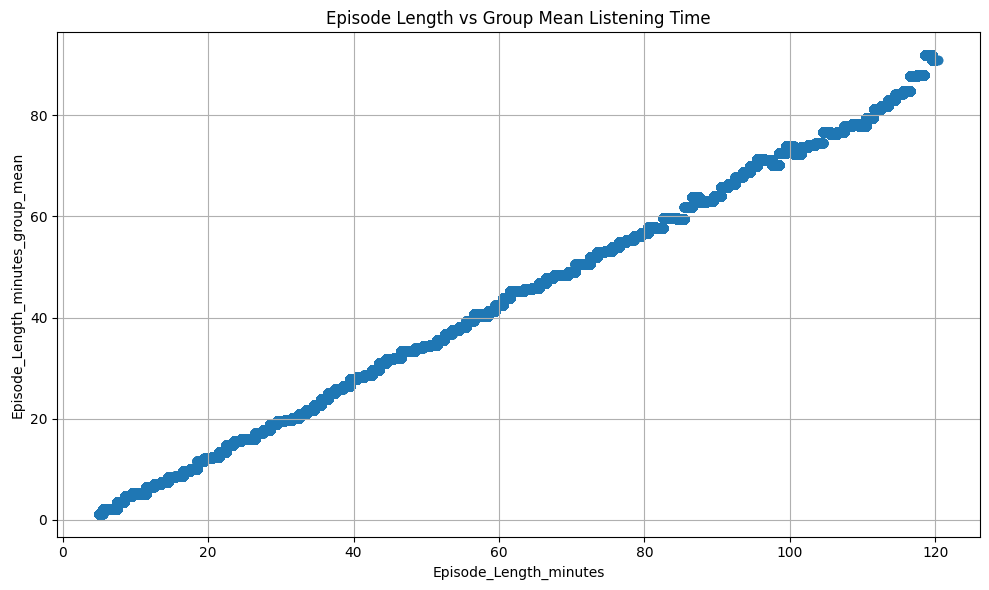

In [231]:
import pandas as pd
import matplotlib.pyplot as plt

# データ読み込み（必要なら）
train = pd.read_csv('../data/train.csv')


# ⑤ trainデータ側にも同じように四捨五入列を作る
train['Episode_Length_rounded'] = train['Episode_Length_minutes'].round()

# ⑥ クリーンなmean_by_episode_lengthをtrainにマッピングする
train['Episode_Length_minutes_group_mean'] = train['Episode_Length_rounded'].map(mean_by_episode_length)
train['Episode_Length_minutes_group_mean'] = train['Episode_Length_minutes'].round().map(mean_by_episode_length)
# ⑥ train側も小数第3位にそろえて準備
# ⑦ グラフ作成（散布図）
plt.figure(figsize=(10, 6))
plt.scatter(train['Episode_Length_minutes'], train['Episode_Length_minutes_group_mean'], alpha=0.6)
plt.xlabel('Episode_Length_minutes')
plt.ylabel('Episode_Length_minutes_group_mean')
plt.title('Episode Length vs Group Mean Listening Time')
plt.grid(True)
plt.tight_layout()
plt.show()

グラフ

<Figure size 1200x600 with 0 Axes>

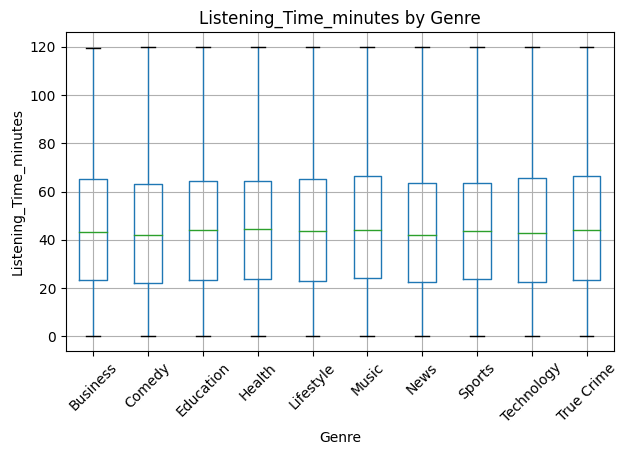

In [93]:
import matplotlib.pyplot as plt

# すでにある train データを使う
plt.figure(figsize=(12, 6))
train.boxplot(column='Listening_Time_minutes', by='Genre')
plt.xlabel('Genre')
plt.ylabel('Listening_Time_minutes')
plt.title('Listening_Time_minutes by Genre')
plt.suptitle('')  # 上に出るデフォルトタイトルを消す
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

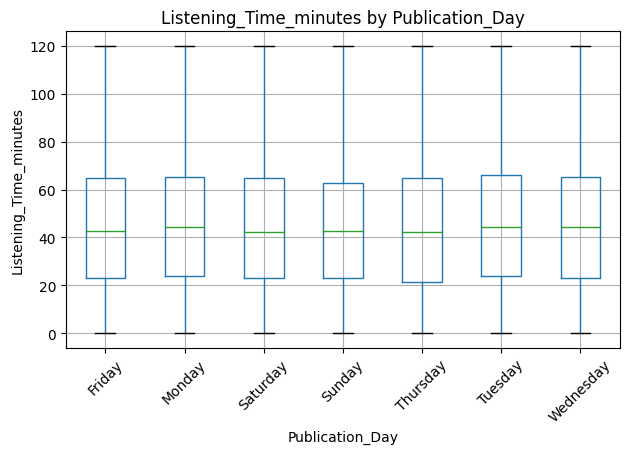

In [95]:
import matplotlib.pyplot as plt

# すでにある train データを使う
plt.figure(figsize=(12, 6))
train.boxplot(column='Listening_Time_minutes', by='Publication_Day')
plt.xlabel('Publication_Day')
plt.ylabel('Listening_Time_minutes')
plt.title('Listening_Time_minutes by Publication_Day')
plt.suptitle('')  # 上に出るデフォルトタイトルを消す
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

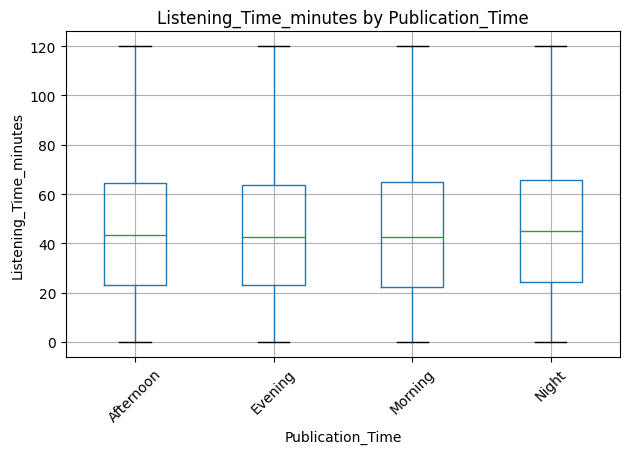

In [97]:
import matplotlib.pyplot as plt

# すでにある train データを使う
plt.figure(figsize=(12, 6))
train.boxplot(column='Listening_Time_minutes', by='Publication_Time')
plt.xlabel('Publication_Time')
plt.ylabel('Listening_Time_minutes')
plt.title('Listening_Time_minutes by Publication_Time')
plt.suptitle('')  # 上に出るデフォルトタイトルを消す
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

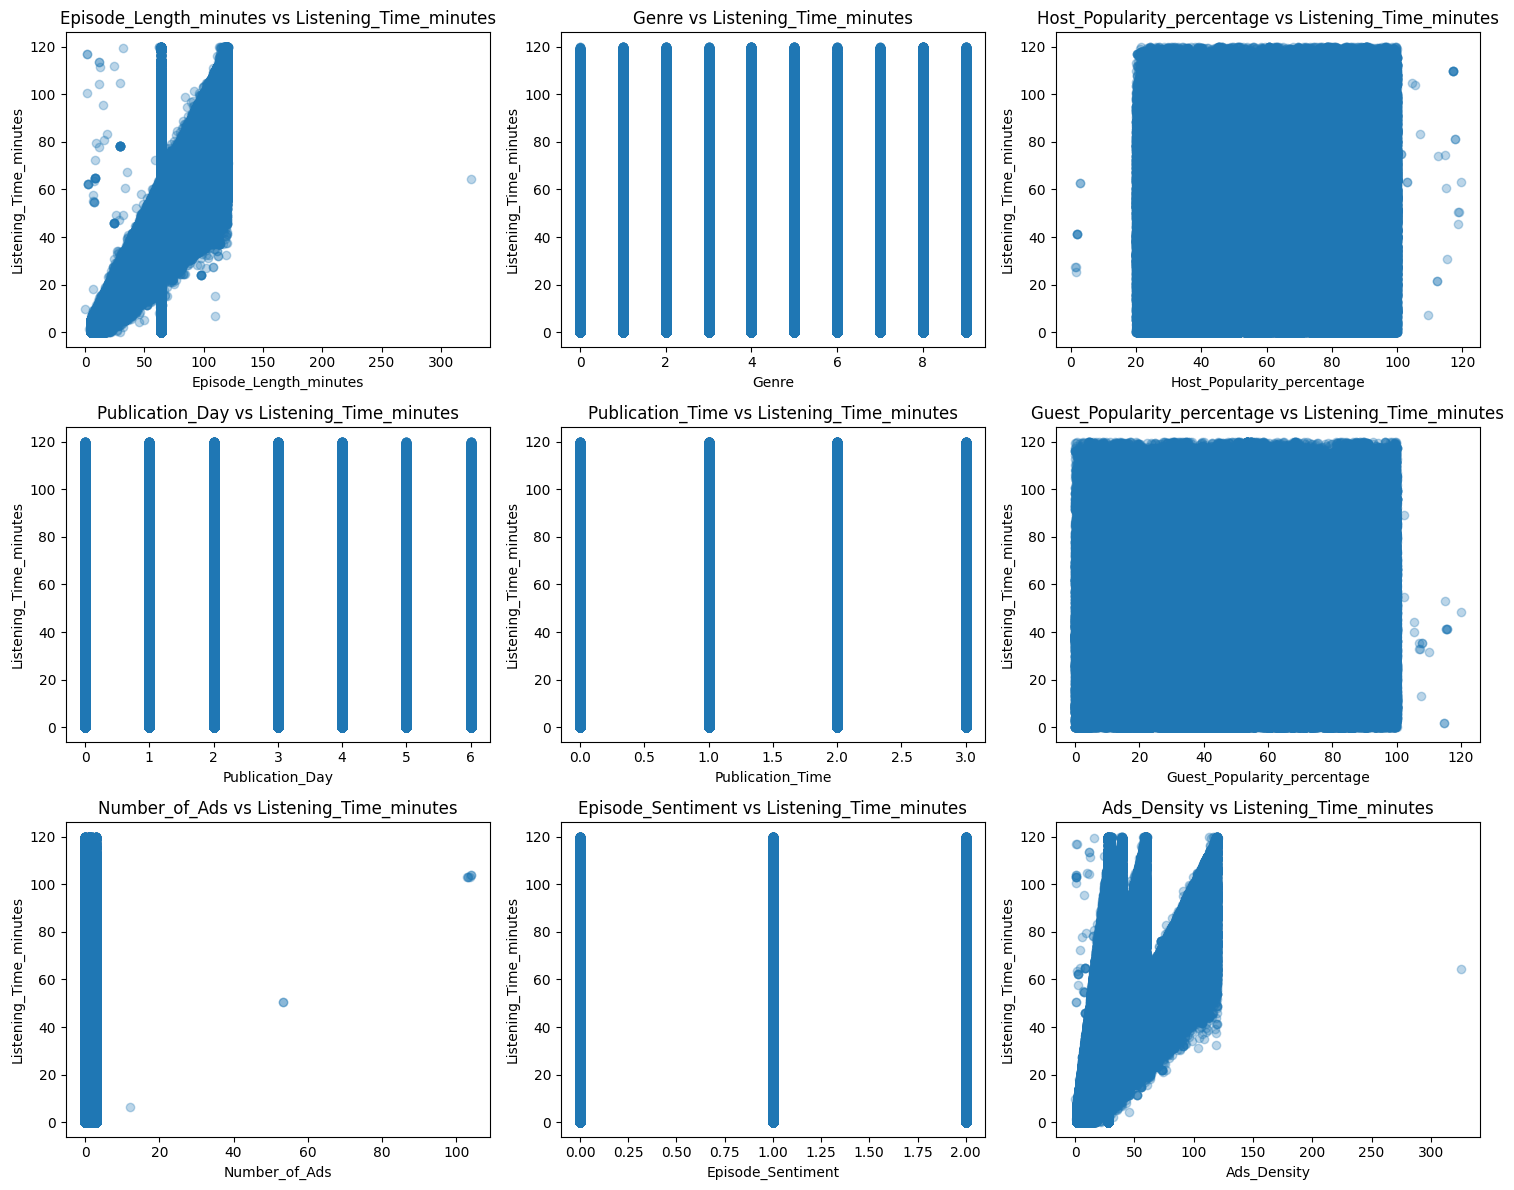

In [99]:
import matplotlib.pyplot as plt

# 特徴量一覧（ターゲット除く）
feature_names = X.columns.tolist()

# グラフの設定
ncols = 3
nrows = (len(feature_names) + ncols - 1) // ncols  # 必要な行数を計算

plt.figure(figsize=(5 * ncols, 4 * nrows))

for idx, feature in enumerate(feature_names):
    plt.subplot(nrows, ncols, idx + 1)
    plt.scatter(X[feature], y, alpha=0.3)
    plt.xlabel(feature)
    plt.ylabel('Listening_Time_minutes')
    plt.title(f'{feature} vs Listening_Time_minutes')

plt.tight_layout()
plt.show()

Guest_Popularity_percentageとHost_Popularity_percentageとpopularity_interractioは相関関係ない

/var/folders/jt/mmrn_vm57216r18c5kg8br600000gn/T/ipykernel_67995/2285445957.py:18: UserWarning: Glyph 12354 (\N{HIRAGANA LETTER A}) missing from current font.
  plt.tight_layout()
/var/folders/jt/mmrn_vm57216r18c5kg8br600000gn/T/ipykernel_67995/2285445957.py:18: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from current font.
  plt.tight_layout()
/var/folders/jt/mmrn_vm57216r18c5kg8br600000gn/T/ipykernel_67995/2285445957.py:18: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from current font.
  plt.tight_layout()
/var/folders/jt/mmrn_vm57216r18c5kg8br600000gn/T/ipykernel_67995/2285445957.py:18: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from current font.
  plt.tight_layout()


<Figure size 600x400 with 0 Axes>

/Users/ozawakousuke/Library/CloudStorage/Box-Box/kaggle/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12354 (\N{HIRAGANA LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ozawakousuke/Library/CloudStorage/Box-Box/kaggle/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ozawakousuke/Library/CloudStorage/Box-Box/kaggle/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12394 (\N{HIRAGANA LETTER NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ozawakousuke/Library/CloudStorage/Box-Box/kaggle/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


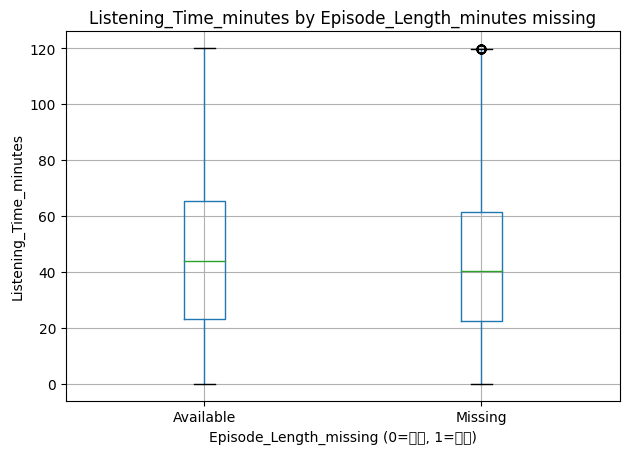

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

# データをもう一度読み込む
train = pd.read_csv('../data/train.csv')

# Episode_Length_minutes が欠損しているかどうかのフラグを作成
train['Episode_Length_missing'] = train['Episode_Length_minutes'].isnull().astype(int)

# グラフ作成
plt.figure(figsize=(6, 4))
train.boxplot(column='Listening_Time_minutes', by='Episode_Length_missing')
plt.xlabel('Episode_Length_missing (0=あり, 1=なし)')
plt.ylabel('Listening_Time_minutes')
plt.title('Listening_Time_minutes by Episode_Length_minutes missing')
plt.suptitle('')
plt.xticks([1, 2], ['Available', 'Missing'])
plt.tight_layout()
plt.show()

In [111]:
import pandas as pd

# データ読み込み（リセットされてる場合は必要）
train = pd.read_csv('../data/train.csv')

# Episode_Length_minutes が欠損しているかどうかのフラグを作成
train['Episode_Length_missing'] = train['Episode_Length_minutes'].isnull().astype(int)

# 欠損あり・なしでListening_Time_minutesの平均を計算
means = train.groupby('Episode_Length_missing')['Listening_Time_minutes'].mean()

# 結果を表示
print('Listening_Time_minutesの平均：')
print('Episode_Length_minutesあり:', means[0])
print('Episode_Length_minutesなし:', means[1])

Listening_Time_minutesの平均：
Episode_Length_minutesあり: 45.73798740105324
Episode_Length_minutesなし: 43.1495378736523


In [120]:
import pandas as pd

# もし必要ならデータ読み込み
train = pd.read_csv('../data/train.csv')

# 順番を指定
day_order = ['Sunday', 'Thursday', 'Friday', 'Saturday', 'Wednesday', 'Monday', 'Tuesday']

# 曜日ごとにListening_Time_minutesの平均を計算して、順番を指定して並べ替える
mean_by_day = train.groupby('Publication_Day')['Listening_Time_minutes'].mean().reindex(day_order)

# 結果を表示
print(mean_by_day)

Publication_Day
Sunday       44.817398
Thursday     44.869706
Friday       45.206591
Saturday     45.326775
Wednesday    45.807177
Monday       45.969630
Tuesday      46.131411
Name: Listening_Time_minutes, dtype: float64


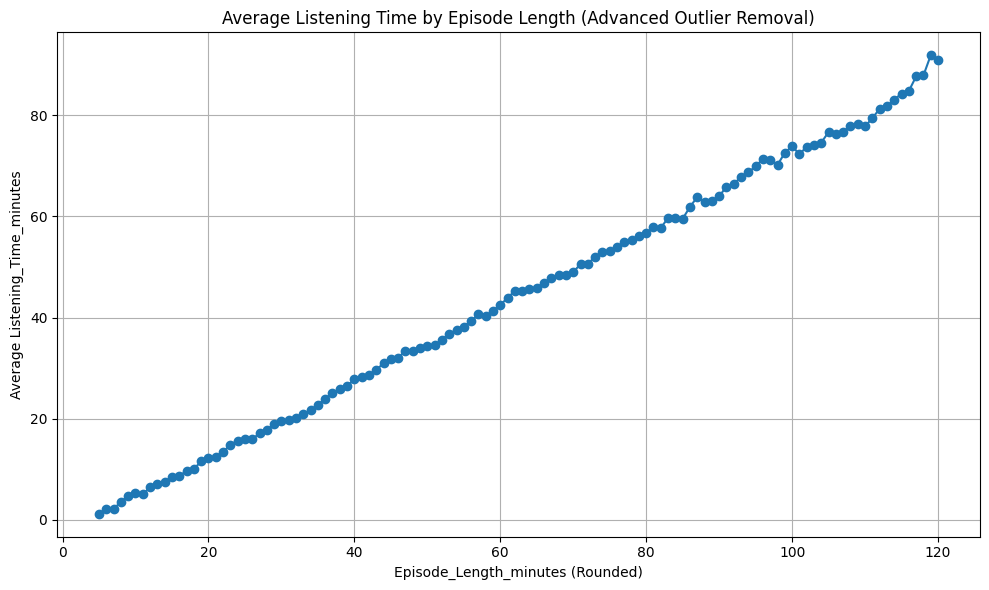

In [149]:
import pandas as pd
import matplotlib.pyplot as plt

# データ読み込み（必要なら）
train = pd.read_csv('../data/train.csv')

# ① IQRを計算して外れ値除去
Q1 = train['Episode_Length_minutes'].quantile(0.25)
Q3 = train['Episode_Length_minutes'].quantile(0.75)
IQR = Q3 - Q1

train_no_outliers = train[
    (train['Episode_Length_minutes'] >= Q1 - 1.5 * IQR) &
    (train['Episode_Length_minutes'] <= Q3 + 1.5 * IQR)
]

# ② Episode_Length_minutesでソートして、最初の3個と最後の1個を除外
train_no_outliers = train_no_outliers.sort_values('Episode_Length_minutes')
train_no_outliers = train_no_outliers.iloc[9:-4]  # 最初3個、最後1個除去


# ④ Episode_Length_minutesを四捨五入してまとめる
train_no_outliers['Episode_Length_rounded'] = train_no_outliers['Episode_Length_minutes'].round()

# ⑤ 四捨五入したEpisode_LengthごとにListening_Time_minutesの平均を計算
mean_by_episode_length = train_no_outliers.groupby('Episode_Length_rounded')['Listening_Time_minutes'].mean()

# ⑥ グラフ描画
plt.figure(figsize=(10, 6))
plt.plot(mean_by_episode_length.index, mean_by_episode_length.values, marker='o')
plt.xlabel('Episode_Length_minutes (Rounded)')
plt.ylabel('Average Listening_Time_minutes')
plt.title('Average Listening Time by Episode Length (Advanced Outlier Removal)')
plt.grid(True)
plt.tight_layout()
plt.show()